In [1]:
#!pip install tqdm

import urllib.request
import zipfile
import os
from tqdm import tqdm

# Function to download a file with a progress bar
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

#url = "https://nlp.stanford.edu/data/glove.6B.zip"
#output = "glove.6B.zip"

# Download the GloVe embeddings with a progress bar
#with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc=url.split('/')[-1]) as t:
    #urllib.request.urlretrieve(url, filename=output, reporthook=t.update_to)


# Unzip the downloaded file
#with zipfile.ZipFile(output, 'r') as zip_ref:
    #zip_ref.extractall()

# Ensure gensim is installed
#!pip install gensim

# Import KeyedVectors from gensim and load the word vectors
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('glove.6B.50d.txt', binary=False, no_header=True)

In [2]:
#!pip install torch torch-geometric

import pandas as pd
import os
from collections import defaultdict, Counter
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ipdb

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.optim import Adam
from torch.nn.functional import cross_entropy
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_auc_score, r2_score, mean_squared_error
from sklearn.utils.class_weight import compute_class_weight
torch.manual_seed(42)

In [3]:
!unzip drive/MyDrive/slt_challenge/transcripts_outputFiles.zip


Archive:  drive/MyDrive/slt_challenge/transcripts_outputFiles.zip
   creating: transcripts_outputFiles/
   creating: transcripts_outputFiles/SFT_outputFiles/
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-103.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-034.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-131.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-039.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-059.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-073.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-030.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-080.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-069.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-test-002.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-083.txt  
  inflating: tra

In [3]:
def load_graph_info(nodes_degree_txt, nodes_edges_txt):
  nodes_features = defaultdict(dict)
  edges = []
  with open(nodes_degree_txt, 'r') as nodes_degree_file, open(nodes_edges_txt, 'r') as nodes_edges_file:
      reading_nodes, reading_edges = False, False

      for line in nodes_edges_file:
          line = line.strip()
          if (not line) or line.startswith("id*int") or line.startswith("source*int"):
              continue

          if line.startswith("*Nodes"):
              # start reading node info
              reading_nodes = True
              reading_edges = False
          elif line.startswith("*DirectedEdges"):
              # start reading edge info
              reading_nodes = False
              reading_edges = True

          elif reading_nodes:
            # parse node info
              parts = line.split(" ", 2)
              node_id = int(parts[0])
              label = parts[1].strip('"')
              nodes_features[node_id]['label'] = label


          elif reading_edges:
            # parse edge info
              parts = line.split()
              source = int(parts[0])
              target = int(parts[1])
              edges.append((source, target))

      for line in nodes_degree_file:
        line = line.strip()
        if (not line) or (not line.startswith("Node Degree")):
          parts = line.split()
          node_id = int(parts[0])
          degree = parts[1].strip('"')
          nodes_features[node_id]['degree'] = degree

      # print(len(nodes_features), len(edges))
      return nodes_features, edges


def get_word_embedding(word, embedding_dim=50):
    try:
        return torch.tensor(word_vectors[word], dtype=torch.float)
    except KeyError:
        # for words not in the vocabulary, use a zero vector
        # print('WARNING: word not in the vocabulary: ', word)
        return torch.zeros(embedding_dim)


def prep_data_for_gnn(nodes_features, edges):
    # mapping from node ID to index
    node_id_to_index = {node_id: i for i, node_id in enumerate(nodes_features.keys())}

    # create node features: node degrees and word embeddings)
    features = []
    for node_id in nodes_features.keys():
        node_label = nodes_features[node_id]['label']
        node_embeddings = get_word_embedding(node_label)
        # print(node_id,nodes_features[node_id]['degree'])
        # new_value = torch.tensor([15], dtype=torch.int64)
        # tensor = torch.cat((node_embeddings, new_value))

        features.append(node_embeddings)
    x = torch.stack(features)  # Node feature matrix

    # create edge index tensor
    edge_index = torch.tensor(
        [[node_id_to_index[src], node_id_to_index[dst]] for src, dst in edges],
        dtype=torch.long,
    ).t().contiguous()
    return x, edge_index


def get_datalist(id_list, label_list, transcript_folder):
  """
  returns a list of Data objects
  """
  data_list = []
  id_label_list = [(id, label) for id, label in zip(id_list, label_list)]
  for id, label in id_label_list:
    filepath = os.path.join(transcript_folder, id)
    nodes_features, edges = load_graph_info(f'{filepath}_dir_nodes_degree.txt', f'{filepath}_dir_nodes_edges.txt')
    x, edge_index = prep_data_for_gnn(nodes_features, edges)
    graph_data = Data(x=x, edge_index=edge_index, y=label)
    data_list.append(graph_data)
  return data_list


def get_dataloader(data_list, batch_size=None):
  if not batch_size:
    batch_size = len(data_list)
    print('Setting batch size to ', batch_size)
  return DataLoader(data_list, batch_size=batch_size, shuffle=False)


def calculate_class_weights(labels):
    class_weights = compute_class_weight(
        class_weight = 'balanced',
        classes = np.unique(labels),
        y = labels)
   
    return torch.tensor(class_weights, dtype=torch.float)

class GNNClassifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNClassifier, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x


def train_gnn(train_datalist, train_batch_size=None, hidden_dim=64, lr=0.01, epoches=250, class_weights=None, num_classes = 3):
  torch.manual_seed(42)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  train_dataloader = get_dataloader(train_datalist, batch_size=train_batch_size)

  num_node_features = next(iter(train_dataloader)).x.size(1)

  model = GNNClassifier(input_dim=num_node_features, hidden_dim=hidden_dim, output_dim=num_classes).to(device)
  optimizer = Adam(model.parameters(), lr=lr)

  # Train
  if class_weights is not None:
      class_weights = class_weights.to(device) 
  loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
  for epoch in range(epoches):  # train for 50 epochs
      model.train()
      total_loss = 0

      for batch in train_dataloader:
          batch = batch.to(device)
          optimizer.zero_grad()
          out = model(batch)
          loss = cross_entropy(out, batch.y)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.5f}')

  return model


def eval_gnn(model, eval_datalist, print_results=True, batch_size=None):
    model.eval()
    logits_list, pred_list, y_list = [], [], []
    eval_dataloader = get_dataloader(eval_datalist, batch_size=batch_size)
    for batch in eval_dataloader:
        logits = model(batch)
        pred = logits.argmax(dim=1)
        logits_list.append(logits)
        pred_list.append(pred)
        y_list.append(batch.y)
    # concatenate data from all batches
    logits_all = torch.cat(logits_list, dim=0)
    pred_all = torch.cat(pred_list, dim=0)
    y_all = torch.cat(y_list, dim=0)
    # get metrics
    results, disp = calc_metrics(y_all, pred_all)
    return logits_all, pred_all, results, disp


def calc_metrics(actual_labels, pred_vals, print_results=True):
  results = {}
  results['accuracy'] = accuracy_score(actual_labels, pred_vals)
  results['f1'] = f1_score(actual_labels, pred_vals, average='macro')
  results['precision'] = precision_score(actual_labels, pred_vals, average='macro')
  results['recall'] = recall_score(actual_labels, pred_vals, average='macro')

  cm = confusion_matrix(actual_labels, pred_vals)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['HC', 'MCI', 'DEM'])
  # print and plot results
  if print_results:
    for metric, value in results.items():
      print(f'{metric}: {value:.3f}')
    disp.plot()
    plt.show()
  return results, disp


class NNMetaModel(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
      super().__init__()
      self.fc1 = Linear(input_dim, hidden_dim)
      self.fc2 = Linear(hidden_dim, output_dim)

  def forward(self, x):
      x = self.fc1(x)
      x = x.relu()
      x = self.fc2(x)
      return x

def train_nn_metamodel(features, labels, class_weights=None, epochs=50, hidden_dim=32, lr=0.01, n_tasks=3):
    num_classes = len(torch.unique(labels))
    input_dim = n_tasks * num_classes  # input dimensions equals to number of tasks (CTD, SFT, PFT) * number of classes
    model = NNMetaModel(input_dim, hidden_dim=hidden_dim, output_dim=num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    if class_weights is not None:
        class_weights = class_weights.to(features.device)  # Move class weights to the same device as the model
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(features)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')
    return model


Fold 0:

    train set for base model: 100 samples; label count: Counter({0: 52, 1: 38, 2: 10}),
    train set for meta model: 25 samples; label count: Counter({0: 13, 1: 10, 2: 2}),
    dev set for meta model: 32 samples; label count: Counter({0: 17, 1: 11, 2: 4})
Class weights for base model:  tensor([0.6410, 0.8772, 3.3333])
Class weights for combined model:  tensor([0.6410, 0.8681, 3.4722])
----------- Task: CTD -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11543
Epoch 50, Loss: 0.42271
Epoch 100, Loss: 0.01576
Epoch 150, Loss: 0.00305
Epoch 200, Loss: 0.00150
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.440
f1: 0.313
precision: 0.315
recall: 0.313


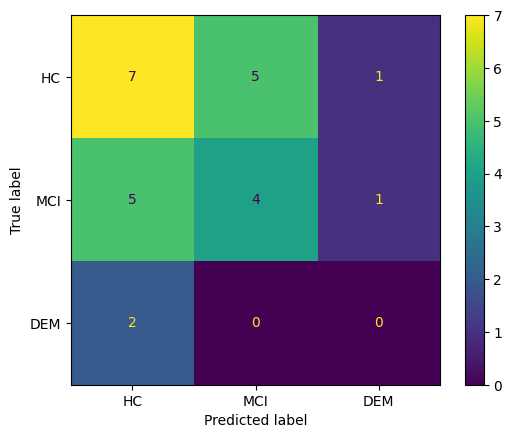

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.500
f1: 0.344
precision: 0.326
recall: 0.367


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


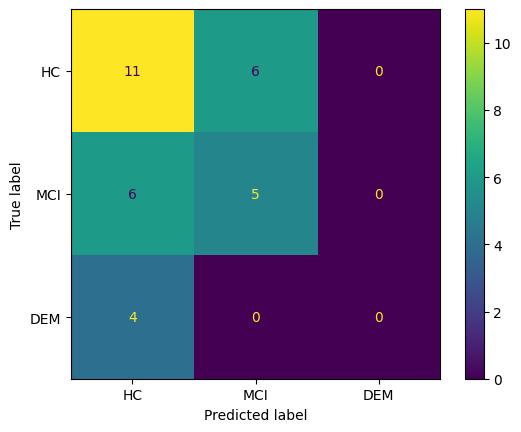

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.11585
Epoch 50, Loss: 0.54414
Epoch 100, Loss: 0.04791
Epoch 150, Loss: 0.00481
Epoch 200, Loss: 0.00213
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.406
f1: 0.293
precision: 0.284
recall: 0.319


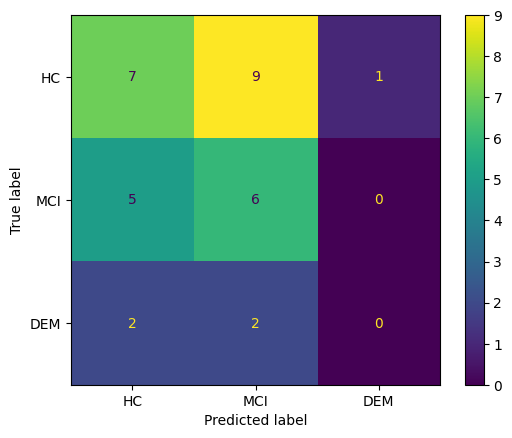

----------- Task: SFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11301
Epoch 50, Loss: 0.20290
Epoch 100, Loss: 0.00277
Epoch 150, Loss: 0.00115
Epoch 200, Loss: 0.00069
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.480
f1: 0.339
precision: 0.340
recall: 0.346


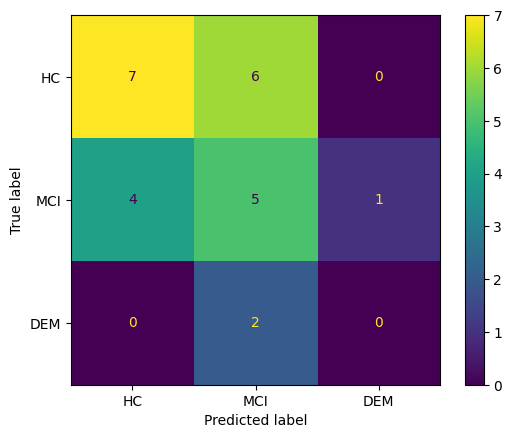

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.469
f1: 0.345
precision: 0.352
recall: 0.369


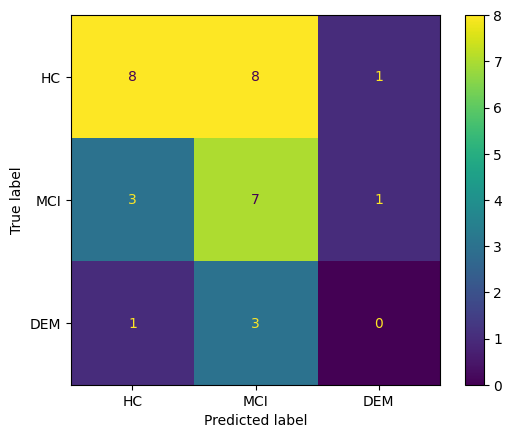

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.11367
Epoch 50, Loss: 0.32773
Epoch 100, Loss: 0.00661
Epoch 150, Loss: 0.00189
Epoch 200, Loss: 0.00104
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.469
f1: 0.339
precision: 0.342
recall: 0.348


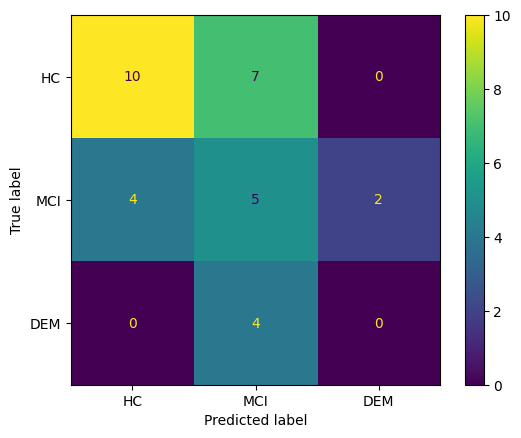

----------- Task: PFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.08362
Epoch 50, Loss: 0.00477
Epoch 100, Loss: 0.00039
Epoch 150, Loss: 0.00024
Epoch 200, Loss: 0.00017
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.520
f1: 0.347
precision: 0.336
recall: 0.364


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


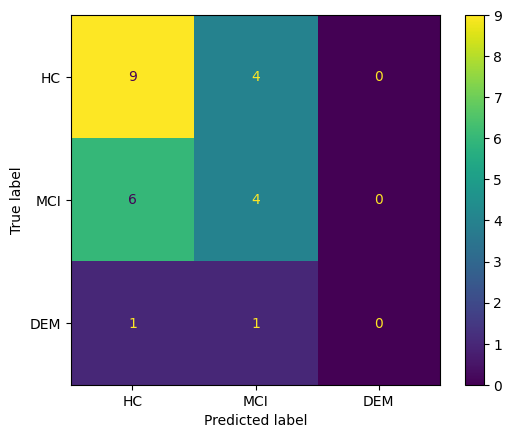

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.531
f1: 0.355
precision: 0.340
recall: 0.376


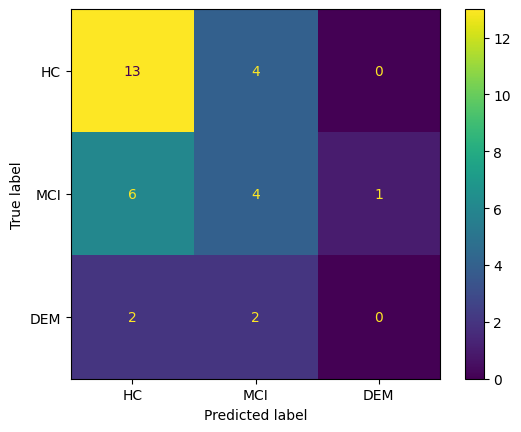

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.08508
Epoch 50, Loss: 0.01183
Epoch 100, Loss: 0.00063
Epoch 150, Loss: 0.00036
Epoch 200, Loss: 0.00024
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.562
f1: 0.463
precision: 0.476
recall: 0.459


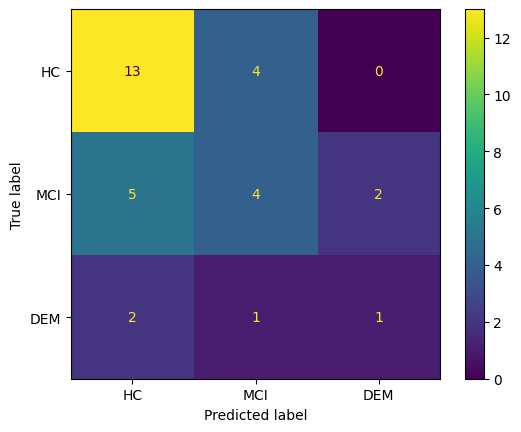

Fold 1:

    train set for base model: 100 samples; label count: Counter({0: 51, 1: 39, 2: 10}),
    train set for meta model: 25 samples; label count: Counter({0: 13, 1: 10, 2: 2}),
    dev set for meta model: 32 samples; label count: Counter({0: 18, 1: 10, 2: 4})
Class weights for base model:  tensor([0.6536, 0.8547, 3.3333])
Class weights for combined model:  tensor([0.6510, 0.8503, 3.4722])
----------- Task: CTD -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11314
Epoch 50, Loss: 0.42359
Epoch 100, Loss: 0.01952
Epoch 150, Loss: 0.00291
Epoch 200, Loss: 0.00143
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.600
f1: 0.401
precision: 0.406
recall: 0.415


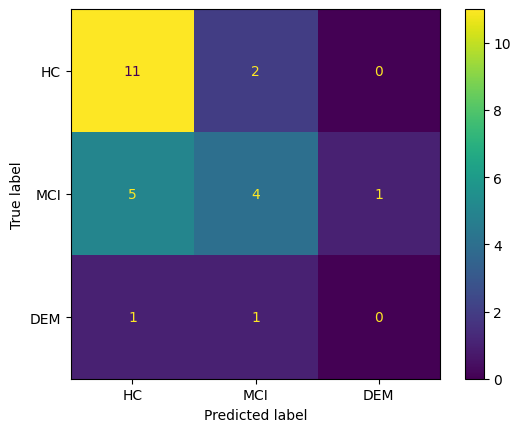

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.406
f1: 0.301
precision: 0.294
recall: 0.320


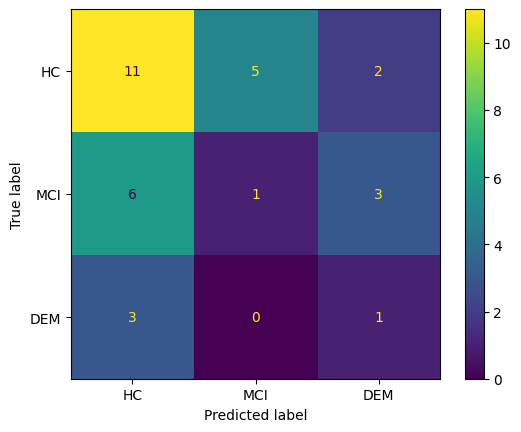

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.11448
Epoch 50, Loss: 0.53648
Epoch 100, Loss: 0.06835
Epoch 150, Loss: 0.00562
Epoch 200, Loss: 0.00244
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.500
f1: 0.420
precision: 0.426
recall: 0.420


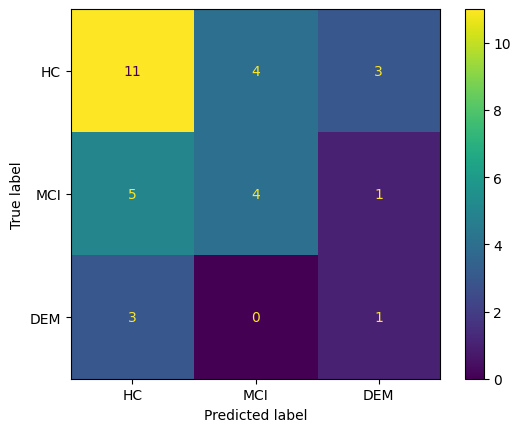

----------- Task: SFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.10681
Epoch 50, Loss: 0.31106
Epoch 100, Loss: 0.00434
Epoch 150, Loss: 0.00143
Epoch 200, Loss: 0.00083
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.400
f1: 0.294
precision: 0.303
recall: 0.287


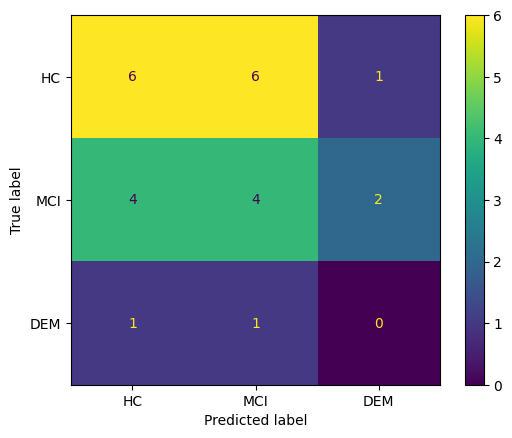

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.531
f1: 0.350
precision: 0.330
recall: 0.374


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


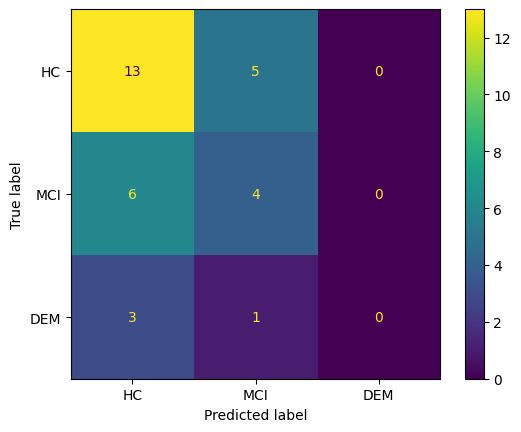

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.11202
Epoch 50, Loss: 0.37347
Epoch 100, Loss: 0.00761
Epoch 150, Loss: 0.00198
Epoch 200, Loss: 0.00110
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.625
f1: 0.400
precision: 0.376
recall: 0.430


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


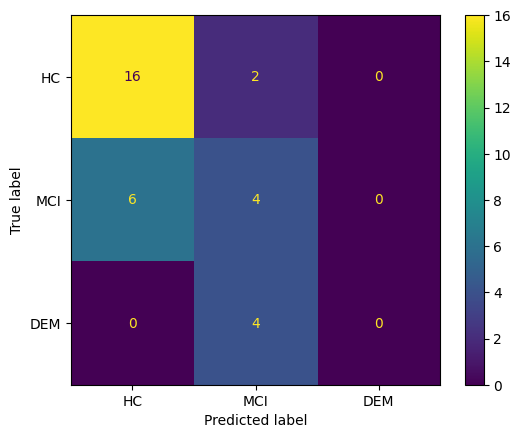

----------- Task: PFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.08090
Epoch 50, Loss: 0.00168
Epoch 100, Loss: 0.00021
Epoch 150, Loss: 0.00015
Epoch 200, Loss: 0.00011
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.520
f1: 0.333
precision: 0.328
recall: 0.356


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


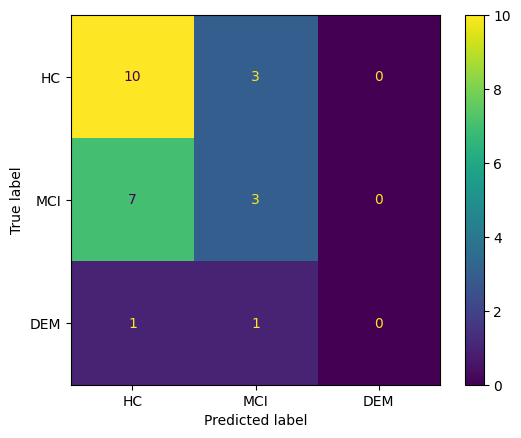

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.562
f1: 0.401
precision: 0.395
recall: 0.407


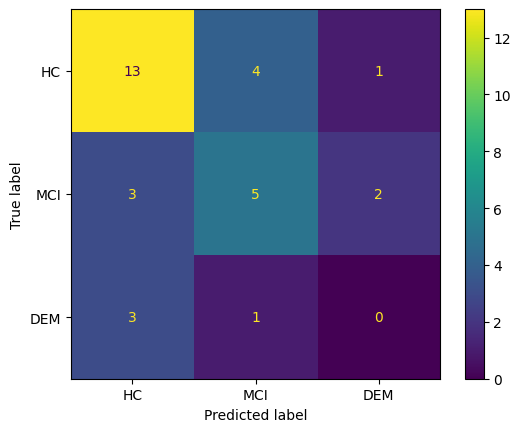

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.08311
Epoch 50, Loss: 0.00556
Epoch 100, Loss: 0.00048
Epoch 150, Loss: 0.00030
Epoch 200, Loss: 0.00021
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.500
f1: 0.369
precision: 0.383
recall: 0.356


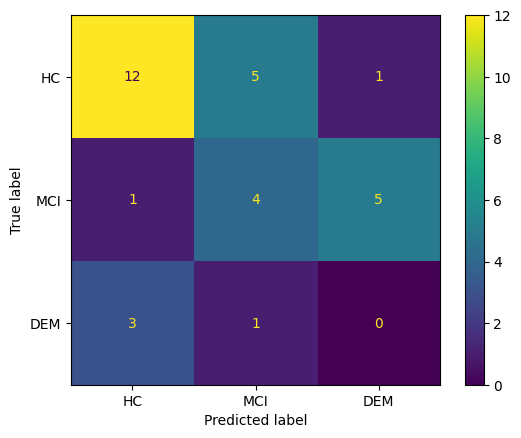

Fold 2:

    train set for base model: 100 samples; label count: Counter({0: 52, 1: 37, 2: 11}),
    train set for meta model: 26 samples; label count: Counter({0: 14, 1: 9, 2: 3}),
    dev set for meta model: 31 samples; label count: Counter({0: 16, 1: 13, 2: 2})
Class weights for base model:  tensor([0.6410, 0.9009, 3.0303])
Class weights for combined model:  tensor([0.6364, 0.9130, 3.0000])
----------- Task: CTD -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11392
Epoch 50, Loss: 0.44964
Epoch 100, Loss: 0.03353
Epoch 150, Loss: 0.00385
Epoch 200, Loss: 0.00170
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.346
f1: 0.248
precision: 0.245
recall: 0.254


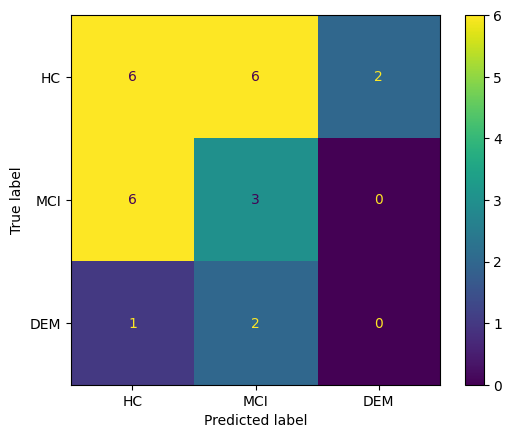

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.419
f1: 0.306
precision: 0.319
recall: 0.295


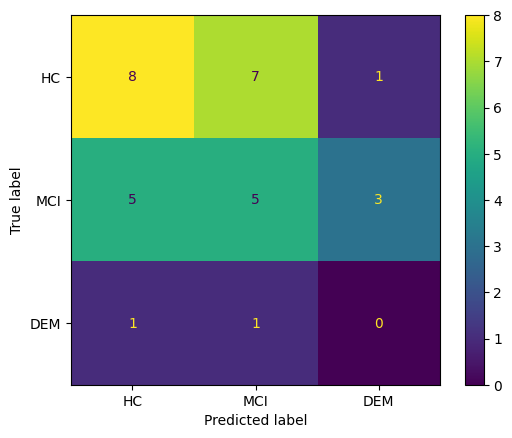

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11444
Epoch 50, Loss: 0.54945
Epoch 100, Loss: 0.07418
Epoch 150, Loss: 0.00669
Epoch 200, Loss: 0.00276
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.516
f1: 0.362
precision: 0.363
recall: 0.362


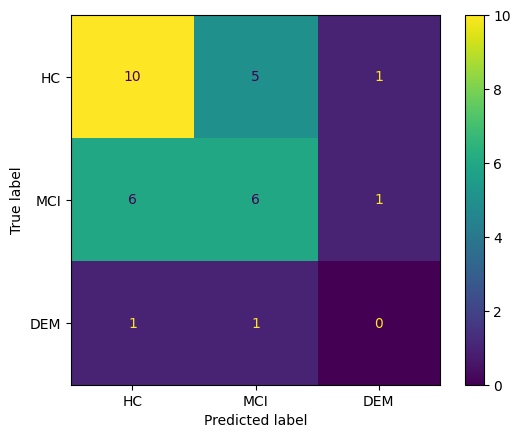

----------- Task: SFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.10724
Epoch 50, Loss: 0.21498
Epoch 100, Loss: 0.00270
Epoch 150, Loss: 0.00104
Epoch 200, Loss: 0.00061
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.577
f1: 0.369
precision: 0.367
recall: 0.397


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


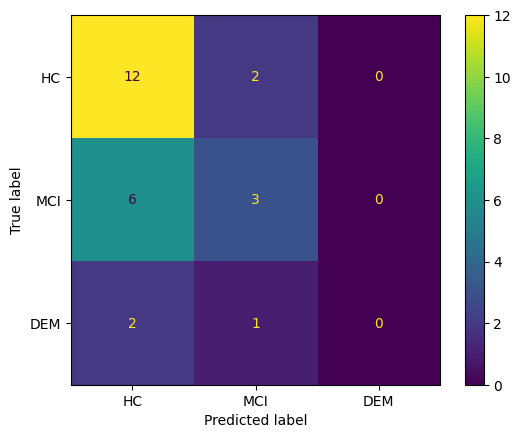

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.484
f1: 0.418
precision: 0.411
recall: 0.478


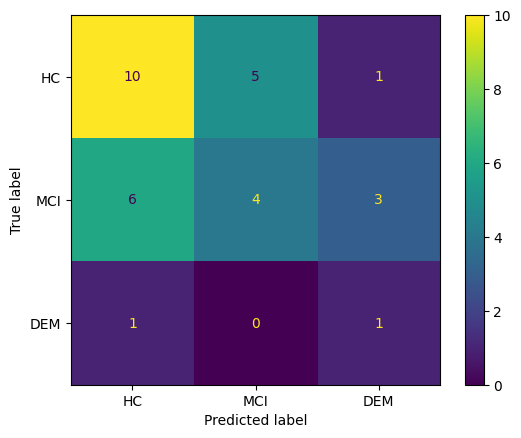

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11161
Epoch 50, Loss: 0.31460
Epoch 100, Loss: 0.00561
Epoch 150, Loss: 0.00157
Epoch 200, Loss: 0.00088
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.452
f1: 0.416
precision: 0.400
recall: 0.462


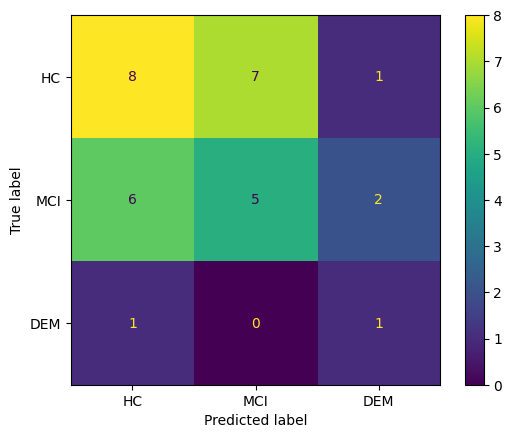

----------- Task: PFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.08702
Epoch 50, Loss: 0.00663
Epoch 100, Loss: 0.00035
Epoch 150, Loss: 0.00021
Epoch 200, Loss: 0.00015
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.500
f1: 0.427
precision: 0.423
recall: 0.437


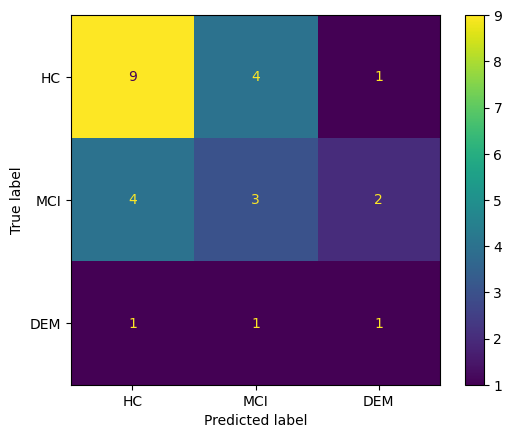

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.516
f1: 0.356
precision: 0.352
recall: 0.362


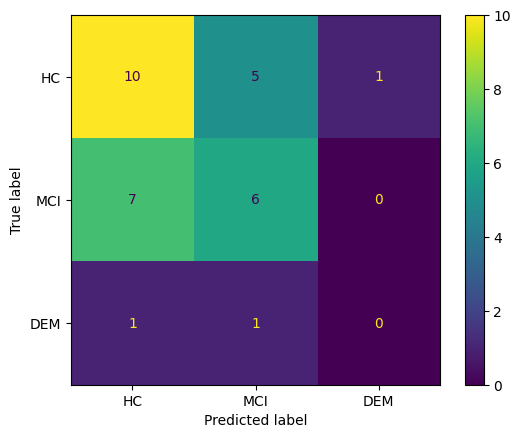

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.08671
Epoch 50, Loss: 0.02133
Epoch 100, Loss: 0.00080
Epoch 150, Loss: 0.00044
Epoch 200, Loss: 0.00029
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.419
f1: 0.287
precision: 0.291
recall: 0.290


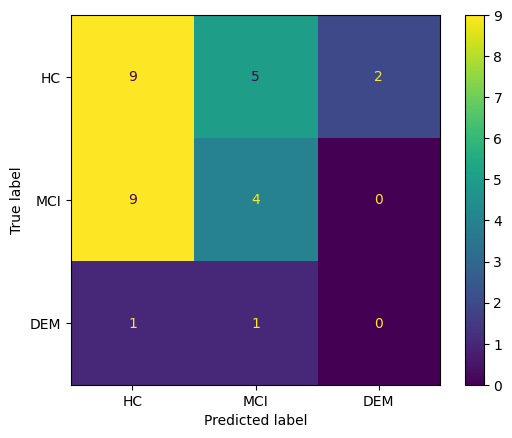

Fold 3:

    train set for base model: 100 samples; label count: Counter({0: 52, 1: 37, 2: 11}),
    train set for meta model: 26 samples; label count: Counter({0: 14, 1: 9, 2: 3}),
    dev set for meta model: 31 samples; label count: Counter({0: 16, 1: 13, 2: 2})
Class weights for base model:  tensor([0.6410, 0.9009, 3.0303])
Class weights for combined model:  tensor([0.6364, 0.9130, 3.0000])
----------- Task: CTD -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11458
Epoch 50, Loss: 0.47936
Epoch 100, Loss: 0.03816
Epoch 150, Loss: 0.00487
Epoch 200, Loss: 0.00226
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.500
f1: 0.361
precision: 0.355
recall: 0.389


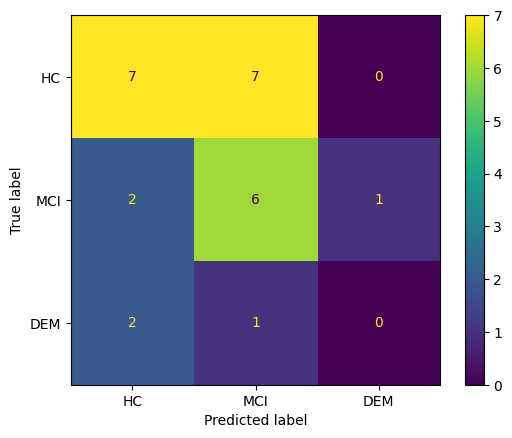

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.581
f1: 0.395
precision: 0.383
recall: 0.409


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


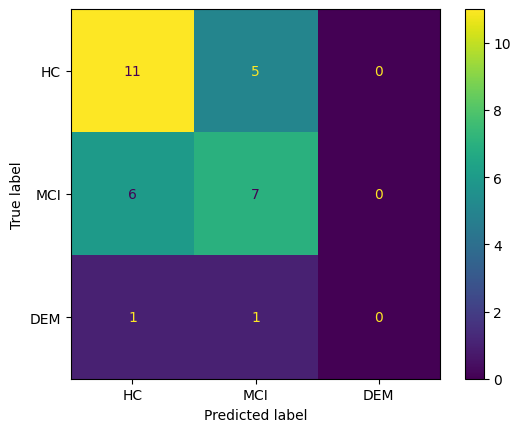

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11445
Epoch 50, Loss: 0.60967
Epoch 100, Loss: 0.11334
Epoch 150, Loss: 0.00974
Epoch 200, Loss: 0.00354
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.548
f1: 0.367
precision: 0.367
recall: 0.378


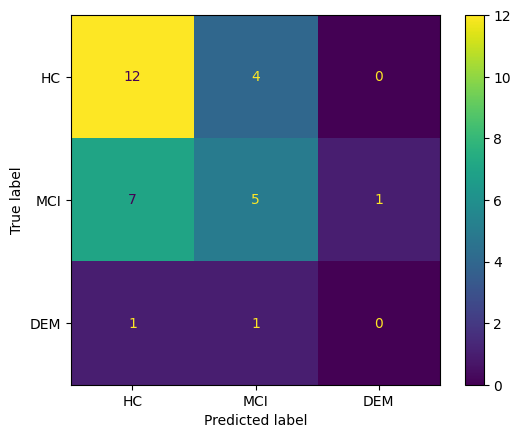

----------- Task: SFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11495
Epoch 50, Loss: 0.12188
Epoch 100, Loss: 0.00177
Epoch 150, Loss: 0.00083
Epoch 200, Loss: 0.00052
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.385
f1: 0.279
precision: 0.285
recall: 0.278


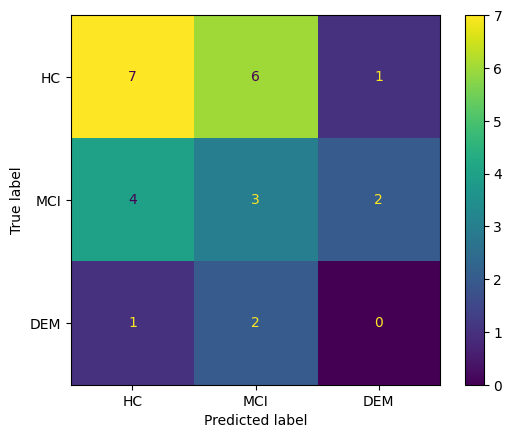

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.548
f1: 0.370
precision: 0.358
recall: 0.383


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


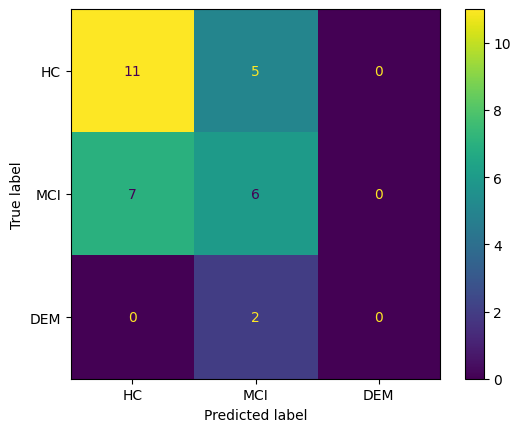

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11406
Epoch 50, Loss: 0.33240
Epoch 100, Loss: 0.00566
Epoch 150, Loss: 0.00182
Epoch 200, Loss: 0.00104
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.581
f1: 0.399
precision: 0.386
recall: 0.413


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


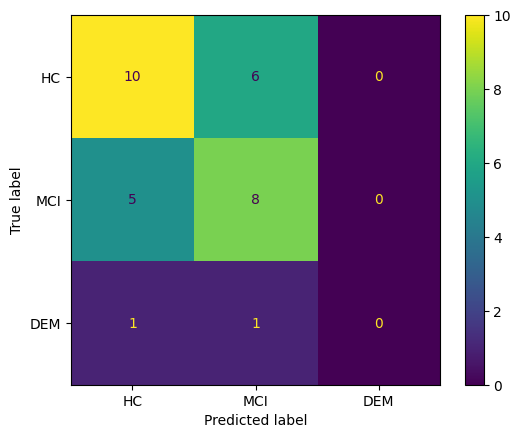

----------- Task: PFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.08676
Epoch 50, Loss: 0.00338
Epoch 100, Loss: 0.00031
Epoch 150, Loss: 0.00019
Epoch 200, Loss: 0.00014
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.423
f1: 0.295
precision: 0.289
recall: 0.302


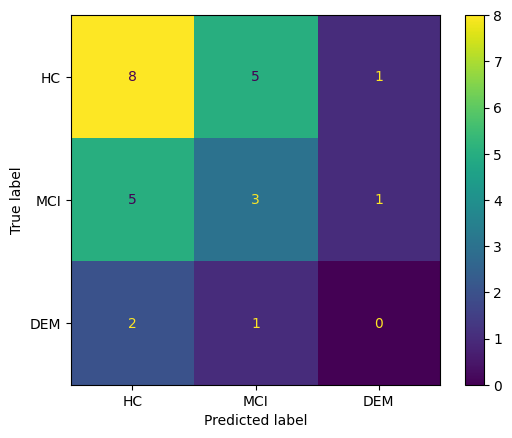

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.387
f1: 0.255
precision: 0.249
recall: 0.264


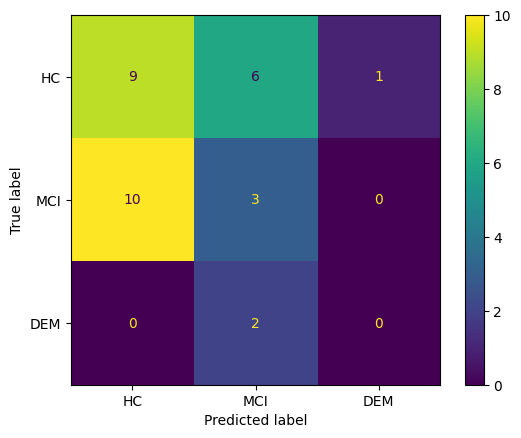

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.08675
Epoch 50, Loss: 0.01383
Epoch 100, Loss: 0.00072
Epoch 150, Loss: 0.00041
Epoch 200, Loss: 0.00027
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.484
f1: 0.337
precision: 0.352
recall: 0.332


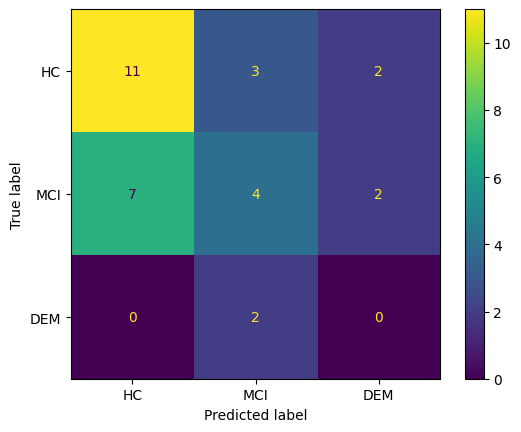

Fold 4:

    train set for base model: 100 samples; label count: Counter({0: 53, 1: 37, 2: 10}),
    train set for meta model: 26 samples; label count: Counter({0: 14, 1: 10, 2: 2}),
    dev set for meta model: 31 samples; label count: Counter({0: 15, 1: 12, 2: 4})
Class weights for base model:  tensor([0.6289, 0.9009, 3.3333])
Class weights for combined model:  tensor([0.6269, 0.8936, 3.5000])
----------- Task: CTD -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11351
Epoch 50, Loss: 0.47012
Epoch 100, Loss: 0.04215
Epoch 150, Loss: 0.00433
Epoch 200, Loss: 0.00176
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.423
f1: 0.303
precision: 0.316
recall: 0.290


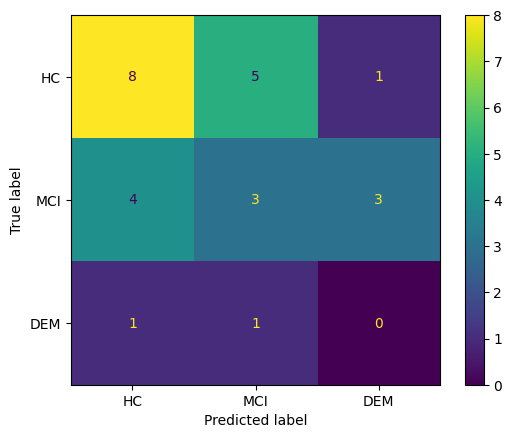

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.387
f1: 0.262
precision: 0.250
recall: 0.283


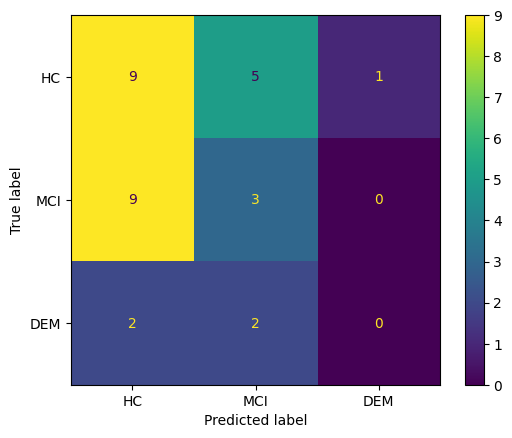

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11510
Epoch 50, Loss: 0.54032
Epoch 100, Loss: 0.08725
Epoch 150, Loss: 0.00823
Epoch 200, Loss: 0.00301
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.452
f1: 0.326
precision: 0.315
recall: 0.339


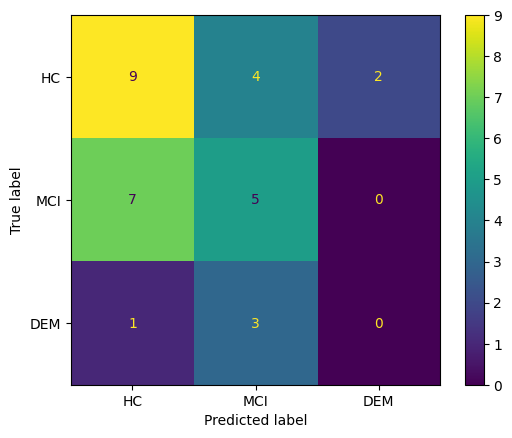

----------- Task: SFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11098
Epoch 50, Loss: 0.23370
Epoch 100, Loss: 0.00291
Epoch 150, Loss: 0.00106
Epoch 200, Loss: 0.00064
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.654
f1: 0.447
precision: 0.438
recall: 0.462


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


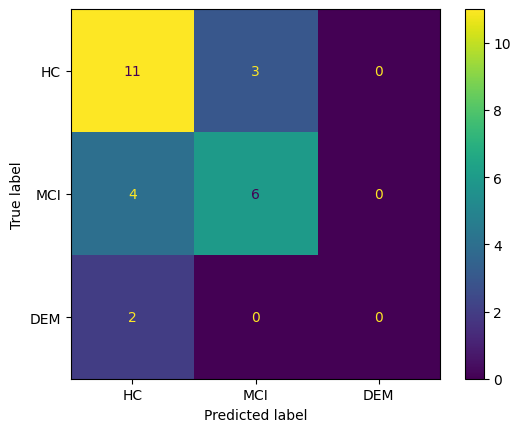

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.484
f1: 0.351
precision: 0.336
recall: 0.372


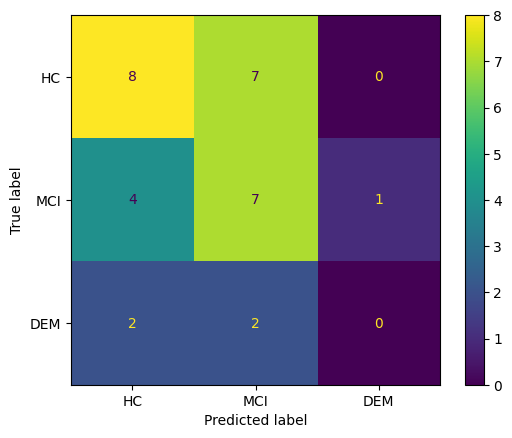

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11199
Epoch 50, Loss: 0.30834
Epoch 100, Loss: 0.00598
Epoch 150, Loss: 0.00171
Epoch 200, Loss: 0.00094
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.484
f1: 0.335
precision: 0.318
recall: 0.361


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


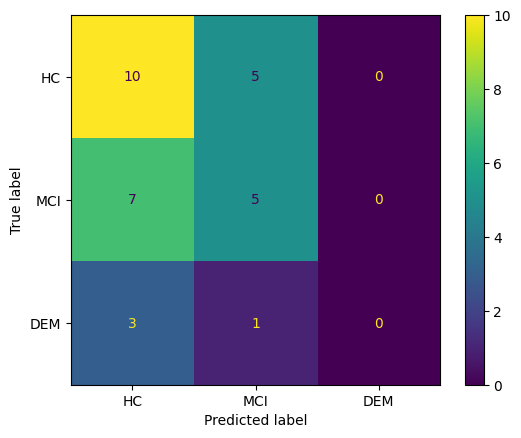

----------- Task: PFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.08546
Epoch 50, Loss: 0.00482
Epoch 100, Loss: 0.00031
Epoch 150, Loss: 0.00020
Epoch 200, Loss: 0.00014
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.423
f1: 0.288
precision: 0.278
recall: 0.300


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


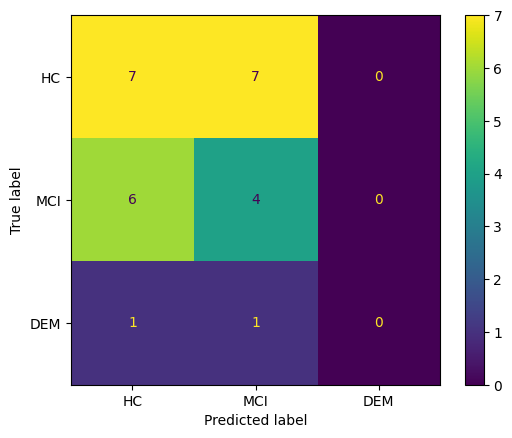

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.323
f1: 0.226
precision: 0.214
recall: 0.239


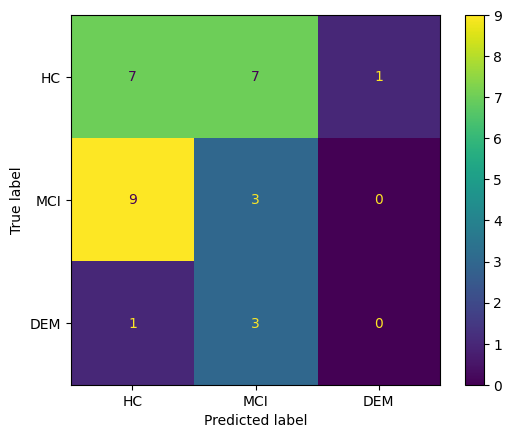

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.08506
Epoch 50, Loss: 0.01188
Epoch 100, Loss: 0.00055
Epoch 150, Loss: 0.00032
Epoch 200, Loss: 0.00022
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.387
f1: 0.340
precision: 0.343
recall: 0.344


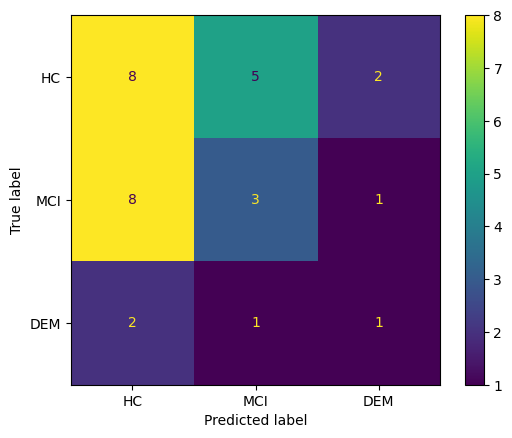


----------- Task: CTD -----------

              precision    recall  f1-score   support

           0       0.56      0.60      0.58        82
           1       0.44      0.44      0.44        59
           2       0.09      0.06      0.07        16

    accuracy                           0.48       157
   macro avg       0.36      0.37      0.36       157
weighted avg       0.47      0.48      0.48       157


----------- Task: SFT -----------

              precision    recall  f1-score   support

           0       0.62      0.66      0.64        82
           1       0.42      0.46      0.44        59
           2       0.17      0.06      0.09        16

    accuracy                           0.52       157
   macro avg       0.40      0.39      0.39       157
weighted avg       0.50      0.52      0.51       157


----------- Task: PFT -----------

              precision    recall  f1-score   support

           0       0.58      0.65      0.61        82
           1       0.

In [6]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TASKS = ['CTD', 'SFT', 'PFT']
LABEL_MAPPING = {'HC': 0,
                 'MCI': 1,
                 'Dementia': 2}

metadata = pd.read_csv("PROCESS_METADATA_ALL.csv")
# shuffle df
metadata = metadata.sample(frac=1, random_state=42, ignore_index=False)
metadata['diagnosis_coded'] = metadata['diagnosis'].map(LABEL_MAPPING)

df_traindev = metadata[metadata['Tr/Tt/Dv'].isin(['train', 'dev'])]
id_traindev, label_traindev = df_traindev['anyon_IDs'], df_traindev['diagnosis_coded']
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf_dict = defaultdict(dict)

all_preds_across_folds = defaultdict(list)
all_trues_across_folds = defaultdict(list)

for fold_index, (train_index, dev_index) in enumerate(skf.split(id_traindev, label_traindev)):
    print(f"Fold {fold_index}:")
    base_train_id, ensemble_train_id, base_train_label, ensemble_train_label = train_test_split(id_traindev[train_index], label_traindev[train_index],
                                                    stratify=label_traindev[train_index],
                                                    test_size=0.2)
    print(f'''
    train set for base model: {len(base_train_label)} samples; label count: {Counter(base_train_label)},
    train set for meta model: {len(ensemble_train_label)} samples; label count: {Counter(ensemble_train_label)},
    dev set for meta model: {len(label_traindev[dev_index])} samples; label count: {Counter(label_traindev[dev_index])}''')

    class_weights_base = calculate_class_weights(base_train_label)
    combined_labels = np.concatenate([base_train_label, ensemble_train_label])
    class_weights_combined = calculate_class_weights(combined_labels)
    print('Class weights for base model: ', class_weights_base)
    print('Class weights for combined model: ', class_weights_combined)

    logits_for_ensemble_training = []
    pred_for_ensemble_training = []

    logits_for_ensemble_validation = []
    pred_for_ensemble_validation = []

    for task in TASKS:
        print(f'----------- Task: {task} -----------')
        transcript_folder = f"transcripts_outputFiles/{task}_outputFiles"
        base_train_datalist = get_datalist(base_train_id, base_train_label, transcript_folder)
        ensemble_train_datalist = get_datalist(ensemble_train_id, ensemble_train_label, transcript_folder)
        ensemble_dev_datalist = get_datalist(id_traindev[dev_index], label_traindev[dev_index], transcript_folder)
        # training gnn in order to get the logits
        print('Training base model...')
        trained_gnn = train_gnn(base_train_datalist, class_weights=class_weights_base)
        # get logits and pred for metamodel training
        print('Validating on meta model train set...')
        task_logits_ensemble_training, task_pred_ensemble_training, _, _ = eval_gnn(trained_gnn, ensemble_train_datalist, print_results=False)
        logits_for_ensemble_training.append(task_logits_ensemble_training)
        pred_for_ensemble_training.append(task_pred_ensemble_training)
        # get logits and pred for metamodel validation
        print('Validating on meta model dev set...')
        task_logits_ensemble_validation, task_pred_ensemble_validation, _, _ = eval_gnn(trained_gnn, ensemble_dev_datalist, print_results=False)
        logits_for_ensemble_validation.append(task_logits_ensemble_validation)
        pred_for_ensemble_validation.append(task_pred_ensemble_validation)

        # for comparison: gnn only, no metamodel
        print('Training on base model train set + meta model train set...')
        trained_gnn_individual_task = train_gnn(base_train_datalist + ensemble_train_datalist, class_weights=class_weights_combined)
        #trained_gnn_individual_task = train_gnn(base_train_datalist + ensemble_train_datalist)
        print('Validating on meta model dev set...')
        _, all_preds, kf_dict[fold_index][f'{task}_gnn_results'], kf_dict[fold_index][f'{task}_gnn_cm_disp'] = eval_gnn(trained_gnn_individual_task, ensemble_dev_datalist)

        all_preds_across_folds[task].extend(all_preds.tolist())
        all_trues_across_folds[task].extend(label_traindev[dev_index].tolist())
        
    kf_dict[fold_index]['logits_for_ensemble_training'] = logits_for_ensemble_training
    kf_dict[fold_index]['logits_for_ensemble_validation'] = logits_for_ensemble_validation
    kf_dict[fold_index]['pred_for_ensemble_training'] = pred_for_ensemble_training
    kf_dict[fold_index]['pred_for_ensemble_validation'] = pred_for_ensemble_validation
    kf_dict[fold_index]['ensemble_train_label'] = ensemble_train_label
    kf_dict[fold_index]['ensemble_dev_label'] = label_traindev[dev_index]

for task in all_preds_across_folds.keys():
    print(f'\n----------- Task: {task} -----------\n')
    print(classification_report(all_trues_across_folds[task], all_preds_across_folds[task]))


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# train and validate meta models
all_preds_meta_model = defaultdict(list)
all_trues_meta_model = defaultdict(list)


for fold in kf_dict.keys():
    print(f"Fold {fold}:")
    fold_dict = kf_dict[fold]
    logits_for_ensemble_training, ensemble_train_label, logits_for_ensemble_validation = fold_dict['logits_for_ensemble_training'], fold_dict['ensemble_train_label'], fold_dict['logits_for_ensemble_validation']
    ensemble_train_features = torch.cat(logits_for_ensemble_training, dim=1).detach()
    ensemble_train_labels = torch.tensor(ensemble_train_label.values, dtype=torch.int64).to(device)
    ensemble_validation_features = torch.cat(logits_for_ensemble_validation, dim=1).detach().to(device)

    class_weights_ensemble = calculate_class_weights(ensemble_train_label)
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights_ensemble.tolist())}
    print(f'Class weights for fold {fold}: ', class_weights_dict)

    lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, class_weight=class_weights_dict)
    svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight=class_weights_dict)
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight=class_weights_dict)
    knn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='minkowski')
    #lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    #svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
    #rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

    # apply machine learning models as metamodel:
    for model_name, ensemble_model in {'lr': lr_model, 'svm': svm_model, 'rf': rf_model, 'knn': knn_model}.items():
        print(f'Training {model_name}...')
        ensemble_model.fit(ensemble_train_features, ensemble_train_labels)
        y_pred = ensemble_model.predict(ensemble_validation_features)
        ensemble_validation_labels = fold_dict['ensemble_dev_label'].to_numpy()
        all_preds_meta_model[model_name].extend(y_pred.tolist())
        all_trues_meta_model[model_name].extend(ensemble_validation_labels.tolist())

    # apply nn model as metamodel:
    nn_meta_model = train_nn_metamodel(features=ensemble_train_features, labels=ensemble_train_labels, class_weights=class_weights_ensemble)
    #nn_meta_model = train_nn_metamodel(features=ensemble_train_features, labels=ensemble_train_labels)
    nn_meta_model.eval()
    with torch.no_grad():
        ensemble_validation_labels = torch.tensor(fold_dict['ensemble_dev_label'].values, dtype=torch.int64).to(device)
        validation_pred = nn_meta_model(ensemble_validation_features).argmax(dim=1)
        all_preds_meta_model['nn'].extend(validation_pred.tolist())
        all_trues_meta_model['nn'].extend(ensemble_validation_labels.tolist())

for model_name in all_preds_meta_model.keys():
    print(f'\n----------- Model: {model_name} -----------\n')
    print(classification_report(all_trues_meta_model[model_name], all_preds_meta_model[model_name]))

Fold 0:
Class weights for fold 0:  {0: 0.6410256624221802, 1: 0.8333333134651184, 2: 4.166666507720947}
Training lr...
Training svm...
Training rf...
Training knn...


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Epoch 10, Loss: 0.3720
Epoch 20, Loss: 0.1636
Epoch 30, Loss: 0.0767
Epoch 40, Loss: 0.0336
Epoch 50, Loss: 0.0158
Fold 1:
Class weights for fold 1:  {0: 0.6410256624221802, 1: 0.8333333134651184, 2: 4.166666507720947}
Training lr...
Training svm...
Training rf...


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training knn...
Epoch 10, Loss: 0.4154
Epoch 20, Loss: 0.2301
Epoch 30, Loss: 0.1259
Epoch 40, Loss: 0.0594
Epoch 50, Loss: 0.0254
Fold 2:
Class weights for fold 2:  {0: 0.6190476417541504, 1: 0.9629629850387573, 2: 2.8888888359069824}
Training lr...
Training svm...
Training rf...


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training knn...
Epoch 10, Loss: 0.5773
Epoch 20, Loss: 0.3148
Epoch 30, Loss: 0.1999
Epoch 40, Loss: 0.1372
Epoch 50, Loss: 0.0963
Fold 3:
Class weights for fold 3:  {0: 0.6190476417541504, 1: 0.9629629850387573, 2: 2.8888888359069824}
Training lr...
Training svm...
Training rf...


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training knn...
Epoch 10, Loss: 0.5636
Epoch 20, Loss: 0.3353
Epoch 30, Loss: 0.1768
Epoch 40, Loss: 0.0903
Epoch 50, Loss: 0.0516
Fold 4:
Class weights for fold 4:  {0: 0.6190476417541504, 1: 0.8666666746139526, 2: 4.333333492279053}
Training lr...
Training svm...
Training rf...


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training knn...
Epoch 10, Loss: 0.4513
Epoch 20, Loss: 0.2329
Epoch 30, Loss: 0.1389
Epoch 40, Loss: 0.0970
Epoch 50, Loss: 0.0716

----------- Model: lr -----------

              precision    recall  f1-score   support

           0       0.54      0.45      0.49        82
           1       0.39      0.46      0.42        59
           2       0.16      0.19      0.17        16

    accuracy                           0.43       157
   macro avg       0.36      0.37      0.36       157
weighted avg       0.44      0.43      0.43       157


----------- Model: svm -----------

              precision    recall  f1-score   support

           0       0.58      0.67      0.62        82
           1       0.45      0.34      0.39        59
           2       0.11      0.12      0.12        16

    accuracy                           0.49       157
   macro avg       0.38      0.38      0.38       157
weighted avg       0.48      0.49      0.48       157


----------- Model: rf -----------

c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera